# notebook to interactively visualize pca, tsne and umap of k-mers density matrix

In [1]:
# =============================================================================
# pip install pandas
# pip install -U scikit-learn
# pip install umap-learn
# pip install matplotlib
# pip install biopython
# pip install joblib
# pip install scipy
# pip install numpy
# pip install tqdm
# =============================================================================



#%%
#import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from umap.umap_ import UMAP
#from umap import UMAP
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.manifold import TSNE
import time
import glob
from joblib import Parallel, delayed
import argparse
import sys

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from tqdm import tqdm

from sklearn.feature_extraction.text import HashingVectorizer
import psutil



import holoviews as hv
from holoviews.operation.datashader import datashade, shade, dynspread
import datashader as ds
import pandas as pd
#import numpy as np

#import panel as pn

from holoviews.plotting.util import process_cmap

import winsound
import colorcet as cc



Load all the fasta sequences in a folder

In [25]:
k = 5  # k-mer length
fasta_folder = r"C:\Users\lorenzo\Desktop\datasets\phagescope\FASTA\phage_fasta\tst" # Specify the folder containing the FASTA files

In [7]:
# Parse Sequences and Create k-mer Frequency Profiles


def get_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# toy example sequences
#toy_sequences = ["AGCTAGC", "TTCGAAG", "AGCTTGC", "AGGCTTGA", "TTAAAAGCACCC", "GCCACCGAACT"]


#fasta_folder = "/fasta_phages" # on cluster

# Find all FASTA files in the folder
fasta_files = glob.glob(fasta_folder + "**/*.fasta", recursive=True)

# Load sequences
sequences = []
prev = 0
for file in fasta_files:
    sequences.extend([str(record.seq) for record in SeqIO.parse(file, "fasta")])
    print(f"Loaded {len(sequences) - prev} sequences from {file}")
    prev = len(sequences)

print(f"Loaded {len(sequences)} sequences")


Loaded 290 sequences from C:\Users\lorenzo\Desktop\datasets\phagescope\FASTA\phage_fasta\tst\DDBJ_combined.fasta
Loaded 156 sequences from C:\Users\lorenzo\Desktop\datasets\phagescope\FASTA\phage_fasta\tst\EMBL_combined.fasta
Loaded 2085 sequences from C:\Users\lorenzo\Desktop\datasets\phagescope\FASTA\phage_fasta\tst\Genbank_combined.fasta
Loaded 2531 sequences


In [8]:
# 3rd option with HashVectorizer
# 
# Step 2: Convert sequences to k-mer frequency profiles using HashingVectorizer


vectorizer = HashingVectorizer(analyzer=lambda seq: get_kmers(seq, k), lowercase=False, n_features=2**20)  # You can adjust n_features as needed
print("starting HashingVectorizer... ")

start = time.time()
X_kmers = vectorizer.fit_transform(sequences)

print("elapsed Vectorizer.fit_transform: " + str(time.time() - start))
#print(f" sparse matrix [{len(sequences)}, {vectorizer.get_feature_names_out().size}]of {X_kmers.data.nbytes} bytes allocated")


starting HashingVectorizer... 
elapsed Vectorizer.fit_transform: 160.52904844284058


In [9]:
# Now that i have the k-mer frequency matrix i can delete sequences from ram
print (f"deleting sequences and freeing {str(sys.getsizeof(sequences))} bytes" )
del sequences

deleting sequences and freeing 20312 bytes


In [ ]:
# INCREMENTAL PCA

# Step 1: Normalize the sparse matrix incrementally
scaler = MaxAbsScaler()
X_kmers = scaler.fit_transform(X_kmers)  # MaxAbsScaler works on sparse matrices directly

# Step 2: Incremental PCA on the sparse matrix
#chunk_size = 1000  # Adjust based on available memory

# Calculate optimal chunk size at runtime
# Estimate the memory size of one dense row
sample_row_dense = X_kmers[0].toarray()
row_size_in_bytes = sample_row_dense.nbytes

# Get available memory in bytes
available_memory = psutil.virtual_memory().available

# Leave 20% of available memory as headroom
memory_headroom = 0.2
usable_memory = available_memory * (1 - memory_headroom)

# Calculate optimal chunk size
chunk_size = int(usable_memory // row_size_in_bytes)

# Set a minimum and maximum limit for chunk size
#chunk_size = max(100, min(chunk_size, 10000))  # Between 100 and 10,000 rows
print(f"Using pca chunk size: {chunk_size}")    


ipca_model = IncrementalPCA(n_components=50)

# Fit IncrementalPCA in batches (convert chunks to dense temporarily)
print("Fitting Incremental PCA:")
num_batches = (X_kmers.shape[0] + chunk_size - 1) // chunk_size
for start in tqdm(range(0, X_kmers.shape[0], chunk_size), total=num_batches, desc="Fitting PCA"):
    end = min(start + chunk_size, X_kmers.shape[0])
    chunk = X_kmers[start:end].toarray()  # Convert chunk to dense
    ipca_model.partial_fit(chunk)

# Transform the data in batches
X_pca = []
print("Transforming data with Incremental PCA:")
for start in tqdm(range(0, X_kmers.shape[0], chunk_size), total=num_batches, desc="Transforming Data"):
    end = min(start + chunk_size, X_kmers.shape[0])
    chunk = X_kmers[start:end].toarray()  # Convert chunk to dense
    X_pca.append(ipca_model.transform(chunk))

# Concatenate results into a single dense array
X_pca = np.vstack(X_pca)

# Save pca to disk
np.save("X_pca.npy", X_pca)

# optionally make a sound when finished
import winsound
duration = 500  # milliseconds
freq = 1000  # Hz
winsound.Beep(freq, duration)


Using pca chunk size: 772
Fitting Incremental PCA:


Fitting PCA: 100%|██████████| 4/4 [38:25<00:00, 576.26s/it]


Transforming data with Incremental PCA:


Transforming Data: 100%|██████████| 4/4 [00:18<00:00,  4.64s/it]


In [11]:
print(f"size X_kmers: {X_kmers.data.nbytes} bytes")
print(f"size X_pca: {X_pca.nbytes} bytes")


size X_kmers: 5199728 bytes
size X_pca: 1012400 bytes


In [12]:
# Now that i have the pca i can delete the frequency matrix from ram
print (f"deleting frequency matrix and freeing {X_kmers.data.nbytes} bytes" )
del X_kmers

deleting frequency matrix and freeing 5199728 bytes


In [3]:
# Load the pca
X_pca = np.load("X_pca.npy")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
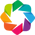

:DynamicMap   []
   :RGB   [PCA1,PCA2]   (R,G,B,A)

In [26]:
#pip install jupyter-bokeh


hv.extension('bokeh')  # Enables interactive plots with the Bokeh backend

# Assuming X_pca and k are already defined
data = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1]})

# Convert the data to a HoloViews Points object
points = hv.Points(data, kdims=['PCA1', 'PCA2'])

# Use datashade to dynamically aggregate and render the points
interactive_plot = datashade(
    points,
    aggregator=ds.count(),
    cmap=cc.fire
)

# Optionally spread out sparse points for better visibility
interactive_plot = dynspread(interactive_plot, threshold=0.5, max_px=1000)

# Customize plot options
interactive_plot = interactive_plot.opts(
    title=f"PCA k = {k}",
    xlabel="PCA Component 1",
    ylabel="PCA Component 2",
    width=800,
    height=600,
    xlim=(-1,3),
    ylim=(-1.5,1.5),
    tools=['box_zoom', 'pan', 'wheel_zoom', 'reset'],
    active_tools=['wheel_zoom'],
    bgcolor='black'
)

# Save the plot to a self-contained HTML file (non zoomable)
hv.save(interactive_plot, f'PCA_plot_k{k}.html', backend='bokeh')

#from datashader.utils import export_image
#export_image(interactive_plot, "out", background="black", export_path=".")

# Save the plot as a TIFF image
#hv.save(interactive_plot, f'PCA_plot_k{k}.png', fmt='png')

# Display the interactive plot in a Jupyter Notebook
interactive_plot

In [13]:
!pip install selenium

   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.7 MB 1.9 MB/s eta 0:00:06
   - -------------------------------------- 0.3/9.7 MB 3.9 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/9.7 MB 4.6 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/9.7 MB 4.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.7 MB 5.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.7 MB 5.8 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.7 MB 5.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.2/9.7 MB 6.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.7 MB 6.2 MB/s eta 0:00:02
   ------------ --------------------------- 3.0/9.7 MB 6.5 MB/s eta 0:00:02
   -------------- ------------------------- 3.5/9.7 MB 6.8 MB/s eta 0:00:01
   ---------------- ----------------------- 4.0/9.7 MB 7.0 MB/s eta 0:00:01
   ----------------

In [18]:
# Step 2: UMAP on the PCA-transformed data
umap_model = UMAP(n_neighbors=5, min_dist=0.1, metric='cosine', low_memory=True)
X_umap = umap_model.fit_transform(X_pca)

In [19]:
X_umap = np.load("X_umap.npy")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
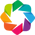

:DynamicMap   []
   :RGB   [UMAP1,UMAP2]   (R,G,B,A)

In [27]:


hv.extension('bokeh')  # Enables interactive plots with the Bokeh backend

# Assuming X_pca and k are already defined
data = pd.DataFrame({'UMAP1': X_umap[:, 0], 'UMAP2': X_umap[:, 1]})

# Convert the data to a HoloViews Points object
points = hv.Points(data, kdims=['UMAP1', 'UMAP2'])

# Use datashade to dynamically aggregate and render the points
interactive_plot = datashade(
    points,
    aggregator=ds.count(),
    cmap=cc.blues
)

# Optionally spread out sparse points for better visibility
#interactive_plot = dynspread(interactive_plot, threshold=0.5, max_px=4)

# Customize plot options
interactive_plot = interactive_plot.opts(
    title=f"UMAP projection after PCA reduction k = {k}",
    xlabel="UMAP Component 1",
    ylabel="UMAP Component 2",
    width=800,
    height=600,
    tools=['box_zoom', 'pan', 'wheel_zoom', 'reset'],
    active_tools=['wheel_zoom'],
    bgcolor = 'black'
)

# Save the plot to a self-contained HTML file (non zoomable)
hv.save(interactive_plot, f'UMAP_plot_k{k}.html', backend='bokeh')

# Display the interactive plot in a Jupyter Notebook
interactive_plot

In [21]:
# Step 3: t-SNE on the PCA-transformed data
tsne_model = TSNE(n_components=2, perplexity=30, metric='cosine')
X_tsne = tsne_model.fit_transform(X_pca)
    

In [21]:
X_tsne = np.load("X_tsne.npy")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
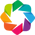

:DynamicMap   []
   :RGB   [t-SNE1,t-SNE2]   (R,G,B,A)

In [28]:
hv.extension('bokeh')  # Enables interactive plots with the Bokeh backend

# Assuming X_pca and k are already defined
data = pd.DataFrame({'t-SNE1': X_tsne[:, 0], 't-SNE2': X_tsne[:, 1]})

# Convert the data to a HoloViews Points object
points = hv.Points(data, kdims=['t-SNE1', 't-SNE2'])

# Use datashade to dynamically aggregate and render the points
interactive_plot = datashade(
    points,
    aggregator=ds.count(),
    cmap=cc.kgy
)

# Optionally spread out sparse points for better visibility
#interactive_plot = dynspread(interactive_plot, threshold=0.5, max_px=4)

# Customize plot options
interactive_plot = interactive_plot.opts(
    title=f"T-sne projection after PCA reduction k = {k}",
    xlabel="T-sne Component 1",
    ylabel="T-sne Component 2",
    width=800,
    height=600,
    tools=['box_zoom', 'pan', 'wheel_zoom', 'reset'],
    active_tools=['wheel_zoom'],
    bgcolor = 'black'
)

# Save the plot to a self-contained HTML file (non zoomable)
hv.save(interactive_plot, f'Tsne_plot_k{k}.html', backend='bokeh')

# Display the interactive plot in a Jupyter Notebook
interactive_plot